# Investigating Gaussian Process Fitting

The aim of this file is to give insights into the fitting of the GP.
Theoretically, the GP should act as a surrogate model to the objective function.
We will investigate this theoretical assumption.

## Setup

### Change Working Directory

In [1]:
# Change working directory to the parent of the parent of the script

import os

# Get the current working directory
current_directory = os.getcwd()

# Get the parent of the parent directory
parent_parent_directory = os.path.abspath(os.path.join(current_directory, '..', '..'))

# Change the working directory to the parent of the parent directory
os.chdir(parent_parent_directory)

# Verify the change by printing the new working directory
print("New working directory:", os.getcwd())


New working directory: /Users/gordianimperial/Documents/Group Project/bo_molecules


### Imports

In [2]:
# Standard library
import random


# Third-party
import gpytorch
import torch
from tdc import Oracle
from gauche.kernels.graph_kernels import WeisfeilerLehmanKernel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from gauche import SIGP, NonTensorialInputs

from botorch.fit import fit_gpytorch_mll, fit_gpytorch_mll
from botorch.settings import debug
from botorch.exceptions.errors import ModelFittingError

In [3]:
# Module Imports
from modules.utils.read_and_sample_molecules import sample_graphs_from_smiles_csv
from modules.utils.molecular_data_conversion import graph_to_smiles, smiles_to_graph
from modules.surrogate_models.gp_model import initialize_model, GraphGP

[04/22/24 13:37:10] WARNING  To use the Graphein submodule                                         embeddings.py:45
                             graphein.protein.features.sequence.embeddings, you need to install:                   
                             biovec                                                                                
                             To do so, use the following command: pip install biovec                               
                             Alternatively, you can install graphein with the extras:                              
                                                                                                                   
                             pip install graphein[extras]                                                          

[04/22/24 13:37:11] WARNING  To use the Graphein submodule graphein.protein.visualisation, you  visualisation.py:36
                             need to install: pytorch3d                                                            
                             pytorch3d cannot be installed via pip                                                 

                    WARNING  To use the Graphein submodule graphein.protein.meshes, you need to        meshes.py:30
                             install: pytorch3d                                                                    
                             To do so, use the following command: pip install pytorch3d                            

### Specifications

In [4]:
n_training_samples = 3000
n_test_samples = 1000

path_to_molecules = "data/zinc.csv"

oracle_name = "albuterol_similarity"

kernel = WeisfeilerLehmanKernel(node_label='element')

### Loading training & test data

We will load the molecules as graph data. This way we can avoid fitting errors due to failed SMILES -> Graph conversions.

In [5]:
n_overall_samples = n_training_samples + n_test_samples

# Read and sample molecules
molecules, _ = sample_graphs_from_smiles_csv(path_to_molecules, n_overall_samples)

# Split the molecules into training and test samples
training_molecules = molecules[:n_training_samples]
test_molecules = molecules[n_training_samples:]
print("Training samples:", len(training_molecules))
print("Test samples:", len(test_molecules))

Sampled 4000 graphs from data/zinc.csv
Training samples: 3000
Test samples: 1000


In [6]:
try:
    objective_function = Oracle(name=oracle_name)
except ValueError:
    raise ValueError(f'The specified objective function {oracle_name} could not be loaded.')

## Experiment

### Fitting the Gaussian Process

In [7]:
smiles_train = [graph_to_smiles(molecule) for molecule in training_molecules]
objective_function_scores = [objective_function(molecule) for molecule in smiles_train]

# Calculate initial objective function scores
y_train = np.array(objective_function_scores, dtype=np.float64)

# Convert labels to PyTorch tensors
y_train = torch.from_numpy(y_train).float()

likelihood = gpytorch.likelihoods.GaussianLikelihood()
x_train_nti = NonTensorialInputs(training_molecules)
mll, model = initialize_model(x_train_nti, y_train, GraphGP, likelihood, kernel)
fit_gpytorch_mll(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-05)
    )
  )
  (model): GraphGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-05)
      )
    )
    (mean): ConstantMean()
    (covariance): WeisfeilerLehmanKernel()
  )
)

### Performing Surrogate Model Call on Test Data

In [8]:
x_test_nti = NonTensorialInputs(test_molecules)

surrogate_labels_test = model(x_test_nti)
surrogate_labels_test_mean = surrogate_labels_test.mean.detach().numpy()
surrogate_labels_test_var = surrogate_labels_test.variance.detach().numpy()
surrogate_labels_test_std = np.sqrt(surrogate_labels_test_var)

In [9]:
print(surrogate_labels_test)
print(type(surrogate_labels_test))
print(surrogate_labels_test_mean)
print(type(surrogate_labels_test_mean))

MultivariateNormal(loc: torch.Size([1000]))
<class 'gpytorch.distributions.multivariate_normal.MultivariateNormal'>
[0.2878561  0.27933908 0.28032637 0.26767945 0.23302841 0.21532631
 0.25493693 0.24831927 0.26510167 0.21162868 0.20294333 0.22346604
 0.26268196 0.22730803 0.18643212 0.20141077 0.23671758 0.24283636
 0.25929546 0.28224683 0.23425364 0.21205711 0.30557126 0.23154664
 0.24023843 0.29316282 0.23506999 0.22221899 0.23178995 0.2786889
 0.20725513 0.29434466 0.24218607 0.27308345 0.24556041 0.3231063
 0.26742268 0.21813464 0.23947048 0.23044252 0.25041246 0.29051185
 0.20745373 0.23383558 0.23954606 0.25698662 0.22919059 0.33467042
 0.22974086 0.19389963 0.24613976 0.18627608 0.22930336 0.2454989
 0.28290284 0.18184233 0.25467932 0.23496675 0.22608471 0.2438783
 0.18909478 0.2252742  0.2832513  0.2483356  0.26666164 0.2547338
 0.29971611 0.20815814 0.22547317 0.17276454 0.23858452 0.27810836
 0.21568656 0.24880481 0.26480472 0.30013204 0.199952   0.23559248
 0.24263287 0.2487

### Performing Oracle Call on Test data

In [10]:
smiles_test = [graph_to_smiles(molecule) for molecule in test_molecules]
gold_labels_test = [objective_function(molecule) for molecule in smiles_test]

In [11]:
print(len(test_molecules))
print(len(surrogate_labels_test_mean))
print(len(gold_labels_test))

1000
1000
1000


### Plotting

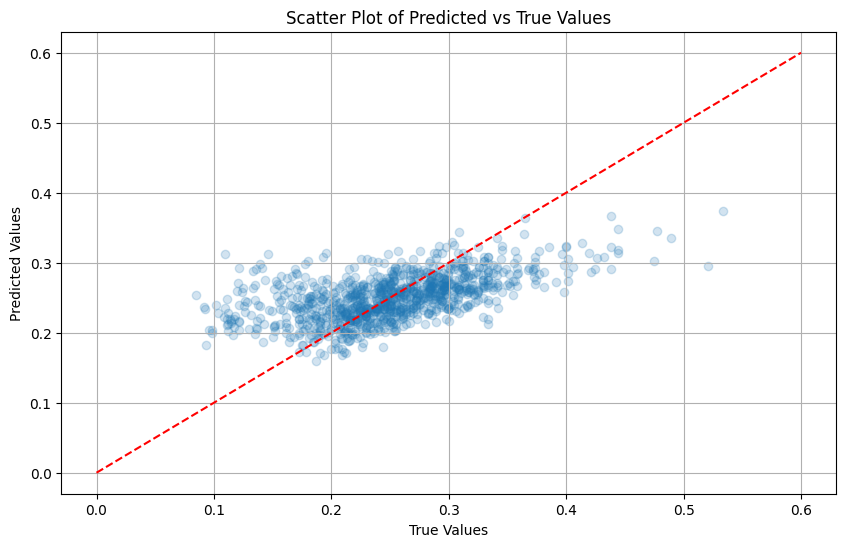

In [18]:
# Scatter plot of predicted vs true values
plt.figure(figsize=(10, 6))
plt.scatter(gold_labels_test, surrogate_labels_test_mean, alpha=0.2)
plt.plot([0, 0.6], [0, 0.6], color='red', linestyle='--')
plt.title('Scatter Plot of Predicted vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

# Line plot to compare trends
# plt.figure(figsize=(10, 6))
# plt.plot(gold_labels_test, label='True Values', marker='o')
# plt.plot(surrogate_labels_test, label='Predicted Values', marker='x')
# plt.title('Line Comparison of Predicted and True Values')
# plt.xlabel('Sample Index')
# plt.ylabel('Value')
# plt.legend()
# plt.grid(True)
# plt.show()


In [ ]:
# # Calculate Mean Absolute Error
# mae = np.mean(np.abs(surrogate_labels_test - gold_labels_test))

# # Calculate Mean Squared Error and Root Mean Squared Error
# mse = mean_squared_error(gold_labels_test, surrogate_labels_test)
# rmse = np.sqrt(mse)

# # Calculate R-squared
# r2 = r2_score(gold_labels_test, surrogate_labels_test)

# print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"Mean Squared Error (MSE): {mse:.2f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
# print(f"R-squared: {r2:.2f}")
